# Numpy

In [1]:
import scipy.io
import pandas
import numpy
import os
from matplotlib import pyplot
from scipy import sparse
import multiprocessing
%matplotlib inline


In [67]:

#carico file dati
percorsoFile = "/home/protoss/Documenti/TESI/DATI/peakmap1.mat.mat"

#print(picchi.shape)
#picchi[0]
#nb: picchi ha 0-tempi
#              1-frequenze
#              4-pesi

#ora popolo il dataframe
tabella = pandas.DataFrame(scipy.io.loadmat(percorsoFile)['PEAKS'])
tabella.drop(tabella.columns[[2, 3]], axis = 1, inplace=True)
tabella.columns = ["tempi", "frequenze","pesi"]

#fascia di sicurezza
securbelt = 4000

headerFreq= scipy.io.loadmat(percorsoFile)['hm_job'][0,0]['fr'][0]
headerSpindown = scipy.io.loadmat(percorsoFile)['hm_job'][0,0]['sd'][0]
epoca = scipy.io.loadmat(percorsoFile)['basic_info'][0,0]['epoch'][0,0]

#nb: headerFreq ha 0- freq minima,
#                  1- step frequenza, 
#                  2- enhancement in risoluzone freq, 
#                  3- freq massima, 
#headerSpindown ha 0- spin down iniziale di pulsar
#                  1- step spindown
#                  2- numero di step di spindown
#Definisco relative variabili per comodità e chiarezza del codice

#frequenze
minFreq = headerFreq[0]
maxFreq = headerFreq[3]
enhancement = headerFreq[2]
stepFrequenza = headerFreq[1]
stepFreqRaffinato = stepFrequenza/enhancement
print(minFreq,maxFreq, enhancement, stepFrequenza, stepFreqRaffinato)

freqIniz = minFreq- stepFrequenza/2 - stepFreqRaffinato
freqFin = maxFreq + stepFrequenza/2 + stepFreqRaffinato
nstepFrequenze = numpy.ceil((freqFin-freqIniz)/stepFreqRaffinato)+securbelt

#spindown
spindownIniz = headerSpindown[0]
stepSpindown = headerSpindown[1]
nstepSpindown = headerSpindown[2].astype(int)


# riarrangio gli array in modo che abbia i dati 
# nel formato che voglio io
frequenze = tabella['frequenze'].values
frequenze = ((frequenze-freqIniz)/stepFreqRaffinato)-round(enhancement/2+0.001)

tempi = tabella['tempi'].values
print(numpy.amax(tempi)-numpy.amin(tempi))
tempi = tempi-epoca
tempi = ((tempi)*3600*24/stepFreqRaffinato)
#tempi = tempi - numpy.amin(tempi)+1
#tempi = tempi.astype(int)

pesi = tabella['pesi'].values

#%reset_selective tabella

#nstepSpindown = 200
spindowns = numpy.arange(0, nstepSpindown)
spindowns = numpy.multiply(spindowns,stepSpindown)
spindowns = numpy.add(spindowns, spindownIniz)
# così ho i tre array delle tre grandezze


nRows = nstepSpindown
nColumns = nstepFrequenze.astype(int)
fakeRow = numpy.zeros(frequenze.size)

def itermatrix(stepIesimo):
    sdPerTempo = spindowns[stepIesimo]*tempi
    appoggio = numpy.round(frequenze-sdPerTempo+securbelt/2).astype(int)
    
    valori = numpy.bincount(appoggio,pesi)
    
    missColumns = (nColumns-valori.size)
    zeros = numpy.zeros(missColumns)
    matrix = numpy.concatenate((valori, zeros))
    return matrix

pool = multiprocessing.Pool()
%time imageMapped = list(pool.map(itermatrix, range(nstepSpindown)))
pool.close
imageMapped = numpy.array(imageMapped)
imageMappedNonsum = imageMapped

semiLarghezza = numpy.round(enhancement/2+0.001).astype(int)
imageMapped[:,semiLarghezza*2:nColumns]=imageMapped[:,semiLarghezza*2:nColumns]-imageMapped[:,0:nColumns - semiLarghezza*2]
imageMapped = numpy.cumsum(imageMapped, axis = 1)

40.0 41.2 10.0 0.0009765625 9.765625e-05
417.93
CPU times: user 80 ms, sys: 8 ms, total: 88 ms
Wall time: 3.07 s


$$ H_{i\:bin} = \left[\nu_{bin}-\left(i\Delta \dot{T} + \dot{T}_0 \right)t_{bin} + 2000\right],\; i = 0,...,n;\; bin= 0,..., nbins$$

$$ H_{i\:bin} = \nu_{bin}-\dot{T}'_i t_{bin} + 2000,\; i = 0,...,n;\; bin= 0,..., nbins$$

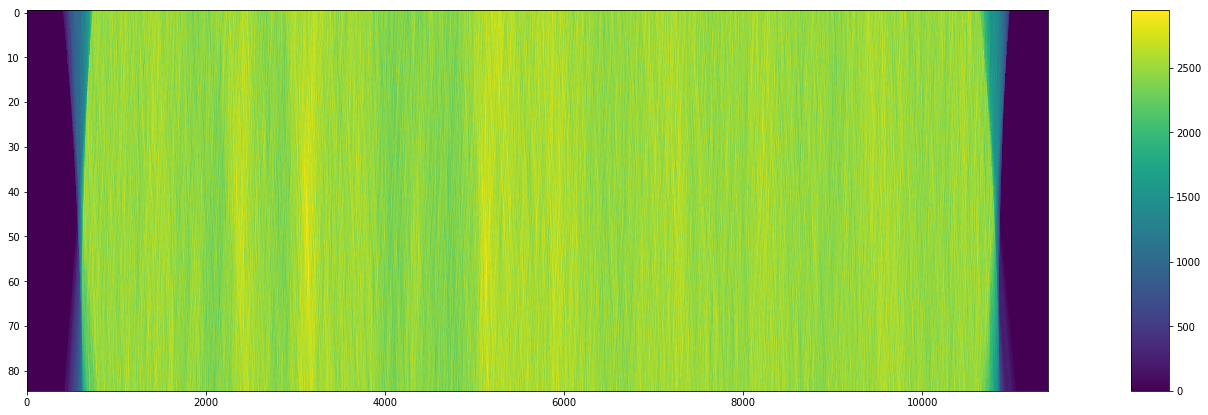

In [63]:
%matplotlib inline
pyplot.figure(figsize=(30,7))
a = pyplot.imshow(imageMapped[:,3400:nColumns-1500], aspect = 50)
pyplot.colorbar(shrink = 1 ,aspect = 10)

[Utile notebook per imshow](http://nbviewer.jupyter.org/github/mgeier/python-audio/blob/master/plotting/matplotlib-colorbar.ipynb)

# Confronti

## Hough dal programma originale in matlab

<function matplotlib.pyplot.show>

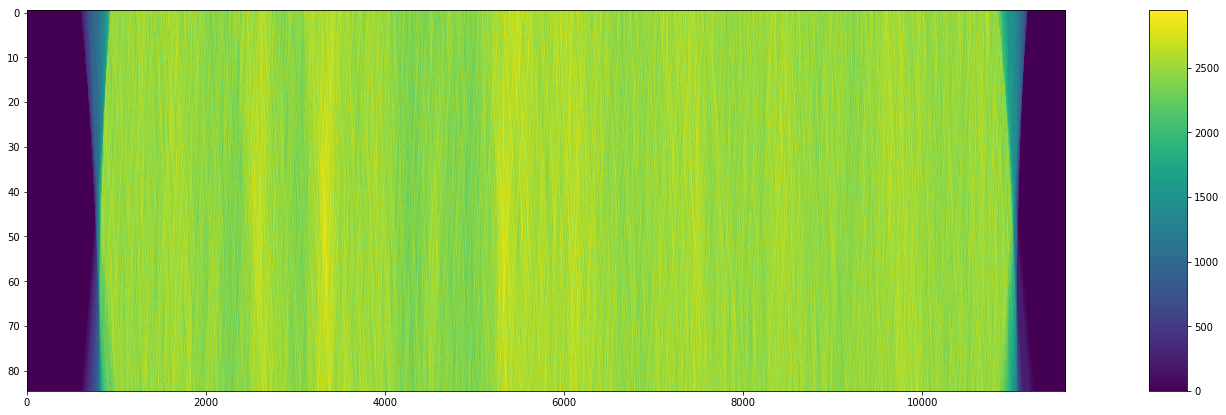

In [64]:
percorsoFile = "originale/concumsum.mat"
percorsoFile2 = "originale/senzacumsum.mat"
immagineOriginale = scipy.io.loadmat(percorsoFile)['binh_df0']
immagineOriginaleNonsum = scipy.io.loadmat(percorsoFile2)['binh_df0']

#percorsoFile = "debugExamples/concumsumDB.mat"
#imgOrigDB = scipy.io.loadmat(percorsoFile)['binh_df0']

pyplot.figure(figsize=(30,7))
pyplot.imshow(immagineOriginale[:,3200:nstepFrequenze.astype(int)-1500],
              #cmap='gray',
              aspect=50)
pyplot.colorbar(shrink = 1,aspect = 10)
#pyplot.colorbar(immagine)
pyplot.show

(array([], dtype=int64), array([], dtype=int64))


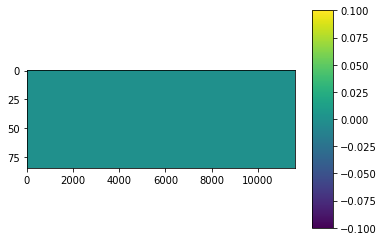

In [65]:
miaVSoriginale = immagineOriginale - imageMapped
#miaVSoriginale = immagineOriginale - imageParalled
#matlabVSoriginale = immagineOriginale - imgOrigDB
#pyplot.figure(figsize=(100, 30))

#verificadoppia = miaVSoriginale - matlabVSoriginale
pyplot.imshow(miaVSoriginale[:,3200:nstepFrequenze.astype(int)-1500],aspect=50)
pyplot.colorbar(shrink = 1,aspect = 10)
print(numpy.nonzero(miaVSoriginale))

(array([], dtype=int64), array([], dtype=int64))


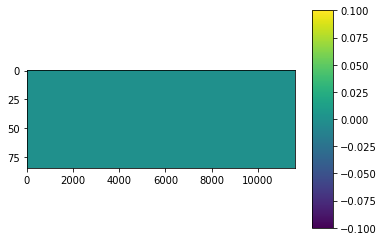

In [11]:
miaVSoriginaleNonsum = immagineOriginaleNonsum - imageMapped
#miaVSoriginale = immagineOriginale - imageParalled
#matlabVSoriginale = immagineOriginale - imgOrigDB
#pyplot.figure(figsize=(100, 30))

#verificadoppia = miaVSoriginale - matlabVSoriginale
pyplot.imshow(miaVSoriginaleNonsum[:,3200:nstepFrequenze.astype(int)-1500],aspect=50)
pyplot.colorbar(shrink = 1,aspect = 10)
print(numpy.nonzero(miaVSoriginaleNonsum))

## Hough dal mio programma in matlab

(85, 16300)


<function matplotlib.pyplot.show>

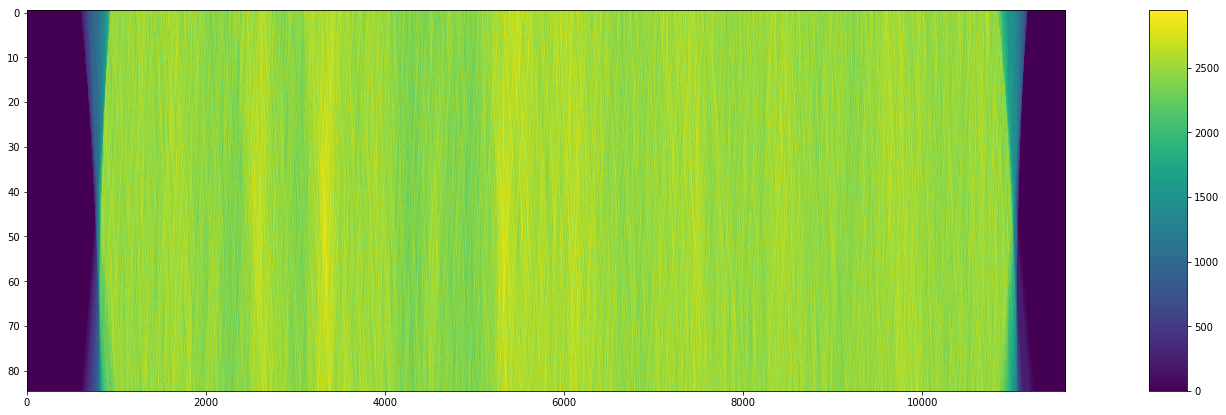

In [59]:
percorsoFile = "matlabbo/miaimgconcumsum.mat"
#percorsoFile = "matlabbo/miaimgnoncumsum.mat"

print(numpy.shape(immagineMatlabbo))
immagineMatlabbo = scipy.io.loadmat(percorsoFile)['hough']
pyplot.figure(figsize=(30, 7))
pyplot.imshow(immagineMatlabbo[:,3200:nstepFrequenze.astype(int)-1500],
              #cmap='gray',
              aspect=50)
pyplot.colorbar(shrink = 1,aspect = 10)
#pyplot.colorbar(immagine)
pyplot.show


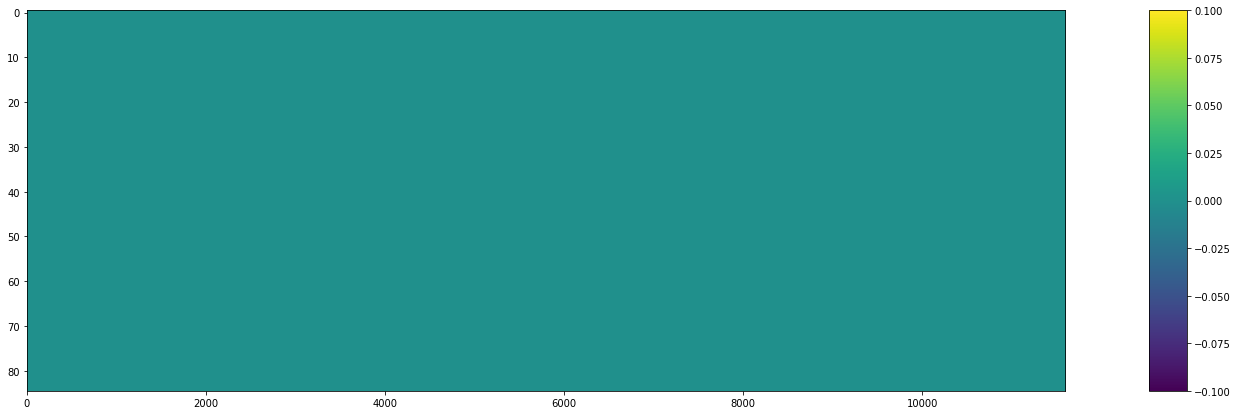

In [60]:
# CONFRONTO
miaMatvsorigMat = immagineMatlabbo - immagineOriginale
#miaMatvsorigMat = immagineMatlabbo - immagineOriginaleNonsum
pyplot.figure(figsize=(30, 7))
pyplot.imshow(miaMatvsorigMat[:,3200:nstepFrequenze.astype(int)-1500],aspect=50)
pyplot.colorbar(shrink = 1,aspect = 10)
#print(numpy.nonzero(verifica))


## Programma semplificato per domande

In [10]:
import numpy
from scipy import sparse
import multiprocessing
from matplotlib import pyplot

#first i build a matrix of some x positions vs time datas in a sparse format
matrix = numpy.random.randint(2, size = 100).astype(float).reshape(10,10)
x = numpy.nonzero(matrix)[0]
times = numpy.nonzero(matrix)[1]
weights = numpy.random.rand(x.size)

#then i define an array of y positions
nStepsY = 5
y = numpy.arange(1,nStepsY+1)

nRows = nStepsY
nColumns = 80
image = numpy.zeros((nRows, nColumns))
fakeRow = numpy.zeros(x.size).astype(int)

CPU times: user 1.58 ms, sys: 469 µs, total: 2.05 ms
Wall time: 1.44 ms


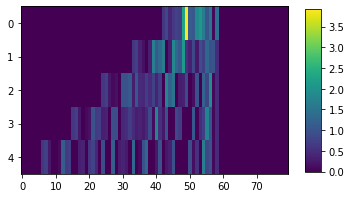

In [11]:
def itermatrix(ithStep):
    yTimed = y[ithStep]*times
    positions = (numpy.round(x-yTimed)+50).astype(int)

    matrix = sparse.coo_matrix((weights, (fakeRow, positions))).todense()
    matrix = numpy.ravel(matrix)
    missColumns = (nColumns-matrix.size)
    zeros = numpy.zeros(missColumns)
    matrix = numpy.concatenate((matrix, zeros))
    return matrix

for i in numpy.arange(nStepsY):
    image[i] = itermatrix(i)

#or, without initialization of image:
%time imageSparsed = list(map(itermatrix, range(nStepsY)))
imageSparsed = numpy.array(imageSparsed)

pyplot.imshow(imageSparsed, aspect = 10)
pyplot.colorbar(shrink = 0.75,aspect = 10)

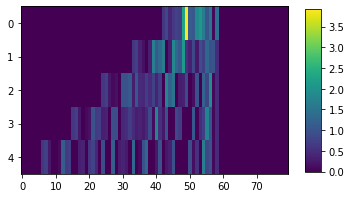

In [12]:
def rowTransform(ithStep):
    yTimed = y[ithStep]*times
    positions = (numpy.round(x-yTimed)+50).astype(int)
    #values = numpy.zeros(nColumns)
    values = numpy.bincount(positions,weights)
#    zeriDopo = tf.zeros([nColumns - values.size])
#    row = numpy.concatenate([values,zeriDopo],0)
    missColumns = (nColumns-values.size)
    zeros = numpy.zeros(missColumns)
    row = numpy.concatenate((values, zeros))
    return row

# definition of the TensorFlow variable and values assignment with tf.map_fn
houghLeft = numpy.zeros([nRows, nColumns])
for i in numpy.arange(nRows):
    houghLeft[i] = rowTransform(i)

pyplot.imshow(houghLeft, aspect = 10)
pyplot.colorbar(shrink = 0.75,aspect = 10)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.51 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.5 ms


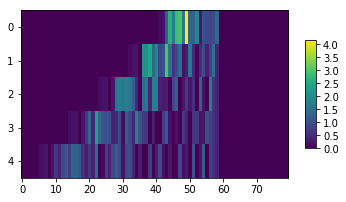

In [79]:
#TEST PARALLELIZZAZIOME MAP
%time imageSparsed = list(map(itermatrix, range(nStepsY)))

pool = multiprocessing.Pool()
%time imageParSparsed = pool.map(itermatrix, range(nStepsY))
pool.close()
imageParalled = numpy.array(imageParSparsed)
#PROBLEMA CON PARALLELIZZAZIONE DA CAPIRE!


%matplotlib inline
#pyplot.figure(figsize=(100, 30))
a = pyplot.imshow(imageParSparsed, aspect = 10)
pyplot.colorbar(shrink = 0.5,aspect = 10)

In [50]:
# riarrangio gli array in modo che abbia i dati 
# nel formato che voglio io
#nstepSpindown = 200
spindowns = numpy.arange(0, nstepSpindown)
spindowns = numpy.multiply(spindowns,stepSpindown)
spindowns = numpy.add(spindowns, spindownIniz)
# così ho i tre array delle tre grandezze
print(spindowns)

[ -1.01056919e-09  -9.86508015e-10  -9.62446844e-10  -9.38385673e-10
  -9.14324502e-10  -8.90263331e-10  -8.66202160e-10  -8.42140988e-10
  -8.18079817e-10  -7.94018646e-10  -7.69957475e-10  -7.45896304e-10
  -7.21835133e-10  -6.97773962e-10  -6.73712791e-10  -6.49651620e-10
  -6.25590449e-10  -6.01529278e-10  -5.77468106e-10  -5.53406935e-10
  -5.29345764e-10  -5.05284593e-10  -4.81223422e-10  -4.57162251e-10
  -4.33101080e-10  -4.09039909e-10  -3.84978738e-10  -3.60917566e-10
  -3.36856395e-10  -3.12795224e-10  -2.88734053e-10  -2.64672882e-10
  -2.40611711e-10  -2.16550540e-10  -1.92489369e-10  -1.68428198e-10
  -1.44367027e-10  -1.20305855e-10  -9.62446844e-11  -7.21835133e-11
  -4.81223422e-11  -2.40611711e-11   0.00000000e+00   2.40611711e-11
   4.81223422e-11   7.21835133e-11   9.62446844e-11   1.20305856e-10
   1.44367027e-10   1.68428198e-10   1.92489369e-10   2.16550540e-10
   2.40611711e-10   2.64672882e-10   2.88734053e-10   3.12795224e-10
   3.36856395e-10   3.60917567e-10

In [ ]:



#nstepSpindown = 200
spindowns = numpy.arange(0, nstepSpindown)
spindowns = numpy.multiply(spindowns,stepSpindown)
spindowns = numpy.add(spindowns, spindownIniz)
# così ho i tre array delle tre grandezze


nRows = nstepSpindown
nColumns = nstepFrequenze.astype(int)
fakeRow = numpy.zeros(frequenze.size)

def itermatrix(stepIesimo):
    sdPerTempo = spindowns[stepIesimo]*tempi
    appoggio = numpy.round(frequenze-sdPerTempo+securbelt/2).astype(int)
   
    matrix = sparse.coo_matrix((pesi, (fakeRow, appoggio))).todense()
    matrix = numpy.ravel(matrix)
    missColumns = (nColumns-matrix.size)
    zeros = numpy.zeros(missColumns)
    matrix = numpy.concatenate((matrix, zeros))
    return matrix

#PROBLEMA CON PARALLELIZZAZIONE DA CAPIRE!
%time imageMapped = list(map(itermatrix, range(nstepSpindown)))
imageMapped = numpy.array(imageMapped)
imageMappedNonsum = imageMapped

semiLarghezza = numpy.round(enhancement/2+0.001).astype(int)
imageMapped[:,semiLarghezza*2:nColumns]=imageMapped[:,semiLarghezza*2:nColumns]-imageMapped[:,0:nColumns - semiLarghezza*2]
imageMapped = numpy.cumsum(imageMapped, axis = 1)